## Задача классификации

- Исследуемый датасет: https://www.kaggle.com/uciml/sms-spam-collection-dataset
- Описание задачи: требуется классифицировать СМС-сообщения как спам и не-спам в зависимости от их содержания.

Импорт библиотек:

In [1]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud
import seaborn as sns
import string
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn import svm

Загрузка обработанного датасета:

In [2]:
df = pd.read_csv('processed_spam_data.csv', encoding = 'latin-1')
del df['Unnamed: 0']
df.head(10)

,target,text,text_length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61
5,spam,FreeMsg Hey there darling it's been 3 week's n...,148
6,ham,Even my brother is not like to speak with me. ...,77
7,ham,As per your request 'Melle Melle (Oru Minnamin...,160
8,spam,WINNER!! As a valued network customer you have...,158
9,spam,Had your mobile 11 months or more? U R entitle...,154


Описание столбцов датасета:
- target - тип сообщения (является ли сообщение спамом)
- text - текст сообщения
- text_length - длина сообщения в символах

Присвоение класса "1" спам-сообщениям и "0" обычным сообщениям:

In [3]:
df['target'] = np.where(df['target'] == 'spam', 1, 0)

ham = []
spam = []
ham_class = df[df['target'] == 0]['text']
spam_class = df[df['target'] == 1]['text']

Функции для выделения слов в сообщениях для каждого класса (кроме английских стоп-слов):

In [4]:
def extract_ham(ham_class):
    global ham
    words = [word.lower() for word in word_tokenize(ham_class) if word.lower() not in stopwords.words("english") and word.lower().isalpha()]
    ham += words
    
def extract_spam(spam_class):
    global spam
    words = [word.lower() for word in word_tokenize(spam_class) if word.lower() not in stopwords.words("english") and word.lower().isalpha()]
    spam += words

In [5]:
ham_class.apply(extract_ham)
spam_class.apply(extract_spam)

2       None
5       None
8       None
9       None
11      None
        ... 
5137    None
5139    None
5146    None
5163    None
5164    None
Name: text, Length: 653, dtype: object

Выделение наиболее часто встречающихся слов в обычных сообщениях:

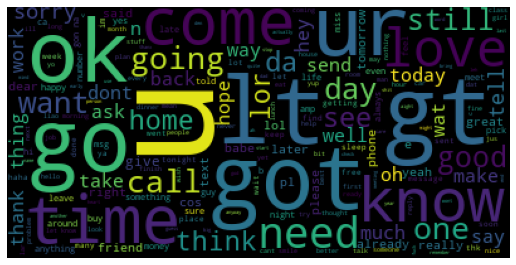

In [6]:
ham_wordcloud = WordCloud().generate(" ".join(ham))
plt.figure(figsize=(9, 9))
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.show()

In [7]:
ham_words = np.array(ham)
pd.Series(ham_words).value_counts().head(20)

u        892
get      293
gt       288
lt       287
go       240
got      236
ok       231
know     225
like     221
good     212
come     211
ur       197
time     188
call     184
love     172
day      166
going    164
want     159
lor      159
one      158
dtype: int64

Выделение наиболее часто встречающихся в спам-сообщениях слов:

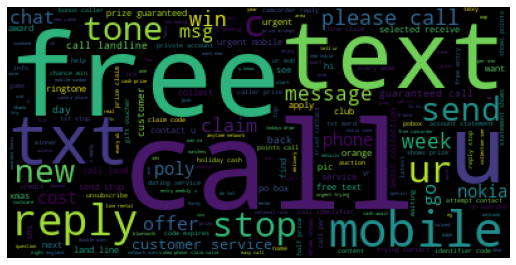

In [8]:
spam_wordcloud = WordCloud().generate(" ".join(spam))
plt.figure(figsize=(9, 9))
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.show()

In [9]:
spam_words = np.array(spam)
pd.Series(spam_words).value_counts().head(20)

call       302
free       191
txt        130
u          122
ur         119
mobile     105
text       104
stop       104
claim       96
reply       96
prize       81
get         70
new         64
send        58
urgent      57
nokia       54
cash        51
contact     51
please      49
service     48
dtype: int64

Построение гистограммы, иллюстрирующей количество сообщений, имеющих определенную длину:

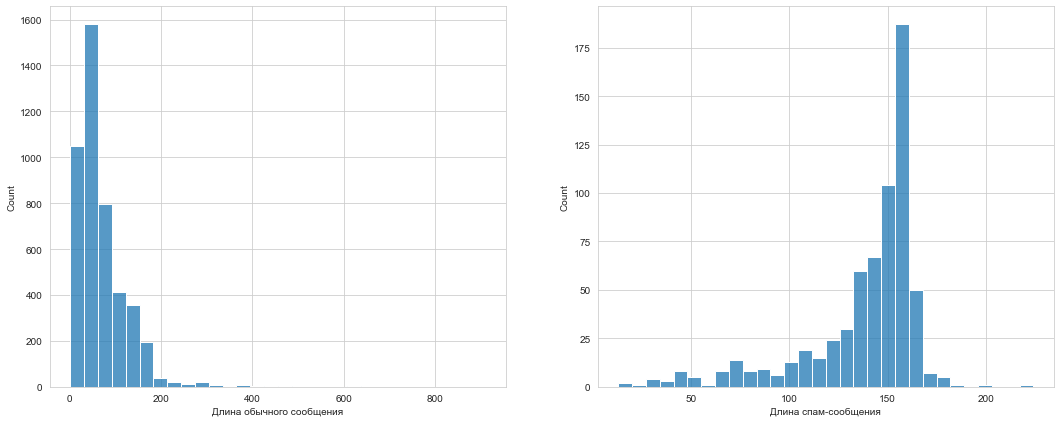

In [10]:
sns.set_style('whitegrid')

f, ax = plt.subplots(1, 2, figsize = (18, 7))

sns.histplot(df[df["target"] == 1]["text_length"], bins = 30, ax = ax[1])
ax[0].set_xlabel("Длина обычного сообщения")

sns.histplot(df[df["target"] == 0]["text_length"], bins = 30, ax = ax[0])
ax[1].set_xlabel("Длина спам-сообщения")

plt.show()

Исходя из данных гистограмм можно сделать вывод о том, что спам-сообщения, как правило, длиннее, чем обычные (основная масса спам-сообщений имеет длину в 130-170 символов против 0-150 символов для обычных сообщений).

Обработка основ (происхождения и корней) слов и удаление пунктуационных знаков:

In [11]:
stemmer = SnowballStemmer("english")

def cleanText(message):
    
    message = message.translate(str.maketrans('', '', string.punctuation))
    words = [stemmer.stem(word) for word in message.split() if word.lower() not in stopwords.words("english")]
    
    return " ".join(words)

df["text"] = df["text"].apply(cleanText)
df.head(10)

,target,text,text_length
0,0,go jurong point crazi avail bugi n great world...,111
1,0,ok lar joke wif u oni,29
2,1,free entri 2 wkli comp win fa cup final tkts 2...,155
3,0,u dun say earli hor u c alreadi say,49
4,0,nah dont think goe usf live around though,61
5,1,freemsg hey darl 3 week word back id like fun ...,148
6,0,even brother like speak treat like aid patent,77
7,0,per request mell mell oru minnaminungint nurun...,160
8,1,winner valu network custom select receivea ã¥â...,158
9,1,mobil 11 month u r entitl updat latest colour ...,154


Нормализация данных (выравнивание количества сообщений обоих классов):

In [12]:
value_count = df['target'].value_counts()
print("Количество сообщений с соответствующим классом до выравнивания соотношения:")
display(value_count)
df = df.sort_values(by = "target", ascending = True).iloc[value_count[0] - value_count[1] : ]
value_count = df['target'].value_counts()
print("\nКоличество сообщений с соответствующим классом после выравнивания:")
display(value_count)

Количество сообщений с соответствующим классом до выравнивания соотношения:


0    4516
1     653
Name: target, dtype: int64


Количество сообщений с соответствующим классом после выравнивания:


1    653
0    653
Name: target, dtype: int64

Разделение данных на обучающую и тестовую выборку:

In [13]:
y = df['target']
x = df['text']

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 123, test_size = 0.25)

Преобразование слов в массив числовых токенов:

In [14]:
cv = CountVectorizer()
x_train = cv.fit_transform(x_train)

### Линейный классификатор (логистическая регрессия)

Вычисление точности при использовании алгоритма логистической регрессии:

In [15]:
lr = LogisticRegression(max_iter = 10000)

lr.fit(x_train, y_train)
prediction = lr.predict(cv.transform(x_test))
print("Точность метода логистической регрессии:", accuracy_score(y_test, prediction))

Точность метода логистической регрессии: 0.9327217125382263


### Метод K ближайших соседей (KNN)

Определение оптимального значения K:

Максимальная точность: 0.7737003058103975 при K = 3


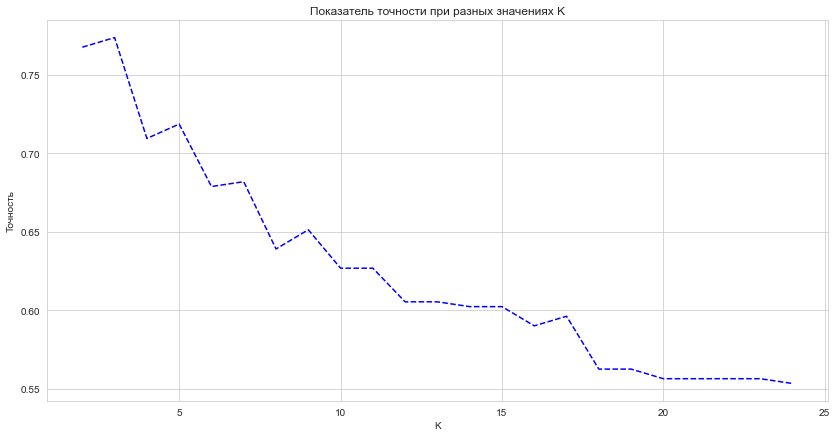

In [16]:
acc = []
default_k = 2

for k in range(default_k, 25):
    knn = KNeighborsClassifier(n_neighbors = k).fit(x_train, y_train)
    yhat = knn.predict(cv.transform(x_test))
    acc.append(metrics.accuracy_score(y_test, yhat))
    
plt.figure(figsize = (14, 7))
plt.plot(range(default_k, 25), acc, color = 'blue', linestyle = 'dashed')
plt.title('Показатель точности при разных значениях K')
plt.xlabel('K')
plt.ylabel('Точность')
print("Максимальная точность:", max(acc), "при K =", acc.index(max(acc)) + default_k)

Максимальная точность алгоритма KNN была получена при обучении с тремя соседями.

### Метод опорных векторов (SVM)

Оценка точности алгоритма с использованием линейного ядра:

In [17]:
svm_classifier = svm.SVC(kernel = 'linear')
svm_classifier.fit(x_train, y_train)
prediction = svm_classifier.predict(cv.transform(x_test))
print("Точность метода опорных векторов:", accuracy_score(y_test, prediction))

Точность метода опорных векторов: 0.926605504587156


При решении данной задачи параметры использованы параметры C и gamma по умолчанию для того, чтобы избежать переобучения.

### Наивный байесовский классификатор (дополнительный метод)

In [18]:
gnb = GaussianNB()
gnb.fit(x_train.todense(), y_train)
prediction = gnb.predict(cv.transform(x_test).todense())
print("Точность наивного байесовского классификатора:", accuracy_score(y_test, prediction))

Точность наивного байесовского классификатора: 0.926605504587156
